# Turn and Stop Sign Classification using NN

- Author: Yiran Jing
- Date: 15 Oct 2020
- Version: 4 (try 11 classes and achieve model goal)

Our model can classify the input images (collected by the donkey car) into 11 classes: 'left_black', 'left_blue', 'left_purple', 'other', 'park_blue', 'park_white','right_black', 'right_blue', 'right_purple', 'speed_50_white', 'stop'

### Model Goal
1. Achieve high accuracy overall classes
2. Low misclassification cost: If the model cannot detect the sign correctly, then classified to “other”(i.e. no action).

#### Dataset Location
[google drive](https://drive.google.com/file/d/1wTuiMjvq8IJT_SM0OYZ4Ogtyo7uVH6RL/view?usp=sharing)


## Content 
1. **EDA**
2. **Feature Engineering**
    1. Configure the dataset for performance (all 240 * 240)
    2. Standardize the data
3. **Train model**
    1. 20% as test data, 80% as train data
    2. three convolution blocks
4. **Model evaluation**
    1. Confusion Matrix
    2. Classification report for each class
         - The overall TEST accuracy is 92%. The model performances good overall.
         - By looking the diagonal presicion of normalised confusion matrix, all classes get more than 93% accuracy, except relatively low value in the class left-turning-purple(92%) and other (89%).
         - The model has relatively high misclassification among `right-blue`, `right-black` and `right-purple(rect)`, which overall is not an issue，since both of them are right-turning sign.
         - The misclassification mainly classifed into `other`, which is what we expected: if the model cannot detect the sign, then classified to `Other`.
         - **The model is not ROBUST: sensitive to the environment noise** (e.g. model think trees are also traffic signs without including enough image of trees in the training dataset)
    3. If not familar with the confusion matrix, please read the link below in more detail of our model evaluation:
         - [Understand and interorete model result based on 5 rules](https://bitbucket.org/RobertJia/comp3988_t17b_group1/wiki/CNN_model_Evaluation)
    4. Appendix : Visualization the misclassification images

***
### Dataset description
The data within folder `signed_map_test_15Oct`, and the data was collectted by donkey car simulator given by different drivers

**Note**: current dataset is unbalanced (too few images in some classes). So the current model result is unreliable. 

- **Train data**: (16353) 
    - other: 6064 images.
    - stop: 976 images.
    - right_blue: 2344 images.
    - right_black: 1173 images.
    - right_purple: 947 images.
    - left_blue: 1552 images.
    - left_black: 656 images.
    - left_purple: 625 images.
    - park_blue: 1287 images.
    - park_white: 214 images.
    - speed_50_white: 515 images.


- **Test data**: (4456)
    - other: 2046 images.
    - stop: 225 images.
    - right_blue: 335 images.
    - right_black: 422 images.
    - right_purple: 339 images.
    - left_blue: 217 images.
    - left_black: 224 images.
    - left_purple: 207 images.
    - park_blue: 281 images.
    - park_white: 70 images.
    - speed_50_white: 90 images.
- Within the train data, we separate 20% data as the validation data to estimate the hyper-parameter turning and avoid overfitting. 
***


### Limitation of CNN model

1. **The model is not ROBUST: sensitive to the environment noise** (e.g. model cannot understand trees without enough training image)
    - Will try add more images for training
    - try advanced feature engineering method
2. Dataset limitation
   - The current dataset is collected based on one map. We will add more kinds of maps' data in the next few weeks.
   - The density of current map is too high. We need to adjust the map and then collect more useful images to train the model


   
### Benefits of current CNN model

1. Our current CNN model has simple structure
2. The model training is fast (around 30 mins using CPU)
3. Can get real-time prediction with no delay, and thus, the car can take action immediately after detected the sign. 

In [23]:
import matplotlib.pyplot as plt
from os import listdir, rename, listdir
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Load dataset and visualization

In [24]:
folder = "signed_map_15Oct"
labels = ["other", "stop", "right_blue", "right_black", "right_purple", "left_blue", 
          "left_black", "left_purple", 'park_blue', "park_white", "speed_50_white"]


In [25]:
print("Train data: ")
data_dir = pathlib.Path(folder+"/train")
image_count = len(list(data_dir.glob('*/*'))) # there are some png, also some jpg
print("The total number of turning images are {}. \n".format(image_count))

for class_name in labels:
    path = folder+"/train/" + class_name
    image_count = len(listdir(path))
    print("{}: {} images.".format(class_name, image_count))


Train data: 
The total number of turning images are 16353. 

other: 6064 images.
stop: 976 images.
right_blue: 2344 images.
right_black: 1173 images.
right_purple: 947 images.
left_blue: 1552 images.
left_black: 656 images.
left_purple: 625 images.
park_blue: 1287 images.
park_white: 214 images.
speed_50_white: 515 images.


In [26]:
print("Test data:")
test_data_dir = pathlib.Path(folder+"/test")
image_count = len(list(test_data_dir.glob('*/*'))) # there are some png, also some jpg
print("The total number of test images are {}. \n".format(image_count))


path = folder+"/test/stop"
for class_name in labels:
    path = folder+"/test/" + class_name
    image_count = len(listdir(path))
    print("{}: {} images.".format(class_name, image_count))
    


Test data:
The total number of test images are 4456. 

other: 2046 images.
stop: 225 images.
right_blue: 335 images.
right_black: 422 images.
right_purple: 339 images.
left_blue: 217 images.
left_black: 224 images.
left_purple: 207 images.
park_blue: 281 images.
park_white: 70 images.
speed_50_white: 90 images.


In [5]:
# Predefined Hyper-parameter 
learning_rate = 0.001
batch_size = 32
img_height = 240
img_width = 240

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% as validation data
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16345 files belonging to 11 classes.
Using 13076 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16345 files belonging to 11 classes.
Using 3269 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir, 
  image_size=(img_height, img_width),
  seed=123, 
  batch_size=batch_size)

Found 4453 files belonging to 11 classes.


In [9]:
class_names = train_ds.class_names
print(class_names) 

['left_black', 'left_blue', 'left_purple', 'other', 'park_blue', 'park_white', 'right_black', 'right_blue', 'right_purple', 'speed_50_white', 'stop']


#### Visualization training data

before we train the model, let's firstly, visualize some training data

From image below, we can see that 

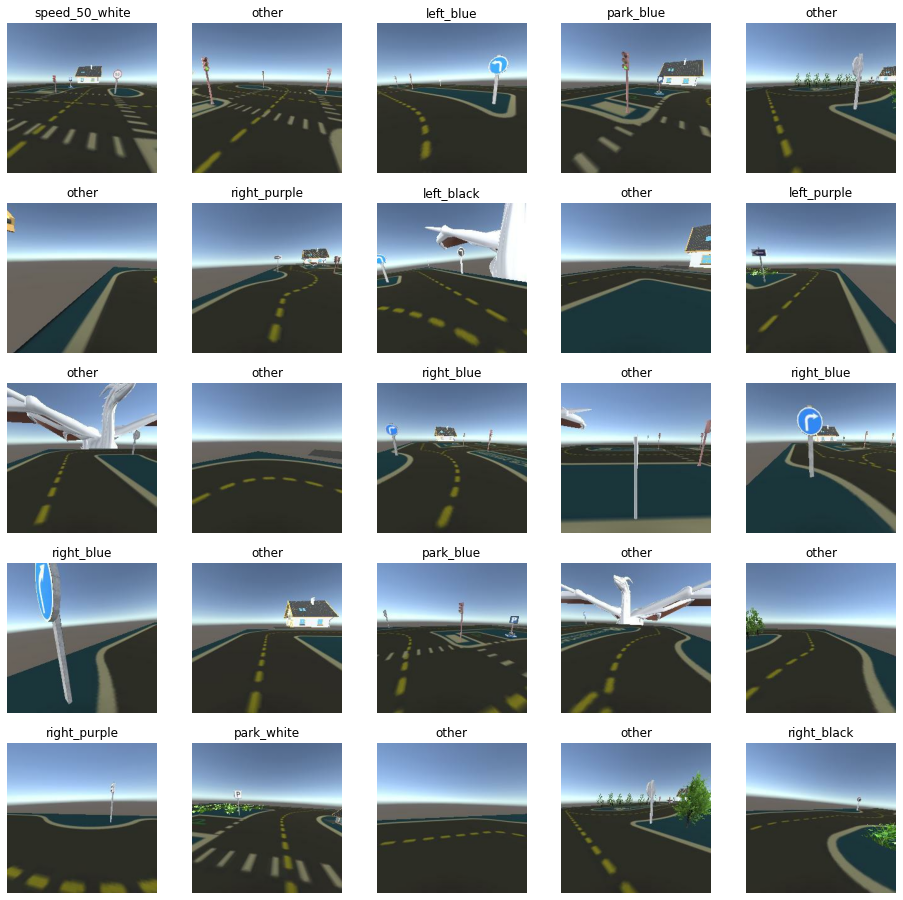

In [10]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 3)
(32,)


### Feature Engineering
1. Configure the dataset for performance
2. Standardize the data


#### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. 

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data
The RGB channel values are in the `[0, 255]` range. 
We standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.03137255 1.0


### Train Model

The model consists of three `convolution blocks` with a `max pool layer` in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, just randomly selected

`relu = max(0, x)`. 

In [15]:
def train_Visualize_CNN(model, 
                        epochs,
                        train_ds, val_ds):
            
    # model compile
    # using Adam optimizer
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            
        
    print(model.summary())
    
    #train model     
    cnn_history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs
        )
    
    return cnn_history

In [16]:
num_classes = len(class_names)
epochs = 4
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2) ## add EarlyStopping
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

cnn_1 = Sequential([
          #data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          #layers.Dropout(drop_out), # drop out rate
          layers.Flatten(),
          layers.Dense(128, activation='relu'), 
          layers.Dense(num_classes)
            ])

cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn_history_1 = cnn_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[callback] # EarlyStopping
)

Epoch 1/4
409/409 [==============================] - 420s 1s/step - loss: 0.7252 - accuracy: 0.7649 - val_loss: 0.2804 - val_accuracy: 0.9162
Epoch 2/4
409/409 [==============================] - 381s 932ms/step - loss: 0.1577 - accuracy: 0.9468 - val_loss: 0.1896 - val_accuracy: 0.9465
Epoch 3/4
409/409 [==============================] - 367s 896ms/step - loss: 0.0695 - accuracy: 0.9776 - val_loss: 0.1072 - val_accuracy: 0.9783
Epoch 4/4
409/409 [==============================] - 382s 935ms/step - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.1386 - val_accuracy: 0.9648


In [17]:
def plot_train_result(model_result, epoch):
    acc = model_result.history['accuracy']
    val_acc = model_result.history['val_accuracy']

    loss=model_result.history['loss']
    val_loss=model_result.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Visualize results

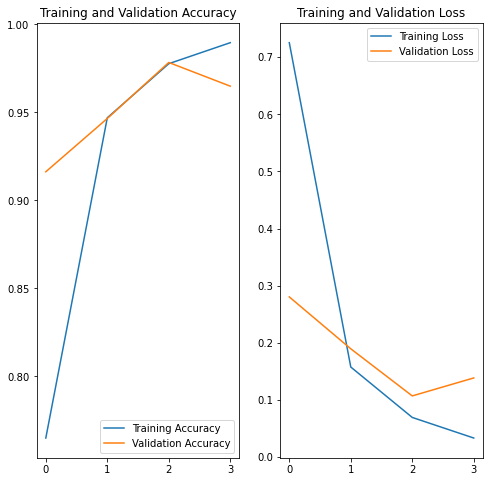

In [18]:
#epochs = 6
plot_train_result(cnn_history_1, epochs)

From the plot above, we can see that the test accuracy is increasing and then decreasing around epoch between 2 and 3. 

## Model evaluation

Reason to add confusion matrix: We select model based on accuracy, but accuracy is just a summary of all classes performance, so to see individual class performance, we should draw confusion matrix. Also, it is good to consider Precision Recall, ROC for each classes.

Based on the test data

### Confusion Matrix

In [19]:
def plot_normalized_confusion_matrix(y_true, y_pred, title, class_names):
    #y_true = np.concatenate([y for x, y in val_ds], axis=0)
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    target_names = class_names
    fig, ax = plt.subplots(figsize=(8,5))
    fig.suptitle(title,fontsize=20)
    ax.set_xlabel("Preidicted_Label")
    ax.set_ylabel('True_Label')
    #plt.xticks(np.arange(0, 60), np.arange(1,60))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, 
            yticklabels=target_names, linewidths=.8,)
    #image_path = 'image/' + model +'_normalized_confusion_matrix.png'
    #fig.savefig(image_path)   
    #plt.close(fig)
    plt.show()  


In [20]:
def draw_confusion_matrix(model, val_ds):
    #Confution Matrix and Classification Report
    Y_pred = model.predict(val_ds)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix, x label is Predicted_Label, y is True_Label')
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    plot_normalized_confusion_matrix(y_true, y_pred, "Normalized Confusion Matrix", class_names) # self-defined function
    
    print('Classification Report bazed on test data')
    #target_names = train_ds.class_names
    target_names = class_names
    print(classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix, x label is Predicted_Label, y is True_Label


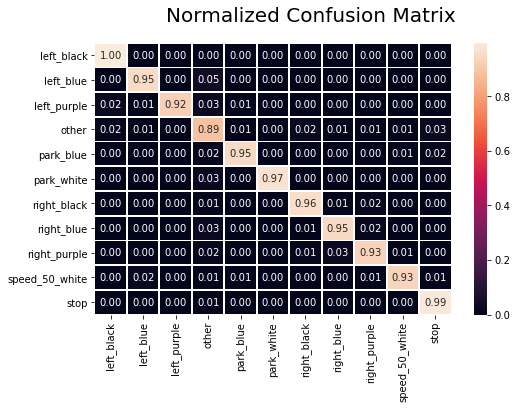

Classification Report bazed on test data
                precision    recall  f1-score   support

    left_black       0.86      1.00      0.92       224
     left_blue       0.92      0.95      0.94       216
   left_purple       0.95      0.92      0.93       207
         other       0.98      0.89      0.93      2045
     park_blue       0.95      0.95      0.95       281
    park_white       0.99      0.97      0.98        70
   right_black       0.88      0.96      0.92       422
    right_blue       0.91      0.95      0.93       335
  right_purple       0.91      0.93      0.92       339
speed_50_white       0.79      0.93      0.86        90
          stop       0.77      0.99      0.86       224

      accuracy                           0.92      4453
     macro avg       0.90      0.95      0.92      4453
  weighted avg       0.93      0.92      0.92      4453



In [21]:
draw_confusion_matrix(cnn_1, test_ds)

If not familar with the confusion matrix, please read the link below in more detail of our model evaluation:
   - [Understand and interorete model result based on 5 rules](https://bitbucket.org/RobertJia/comp3988_t17b_group1/wiki/CNN_model_Evaluation)

#### Model performance
- The overall TEST accuracy is 92%. The model performances good overall.
- By looking the diagonal presicion of normalised confusion matrix, all classes get more than 93% accuracy, except relatively low value in the class left-turning-purple(92%) and other (89%).
- The model has relatively high misclassification among `right-blue`, `right-black` and `right-purple(rect)`, which overall is not an issue，since both of them are right-turning sign.
- The misclassification mainly classifed into `other`, which is what we expected: if the model cannot detect the sign, then classified to `Other`.

In [22]:
# save model
cnn_1.save('sign_15Oct_11Classes.h5')

### Check misclassification images

In [28]:
def draw_missclassification_images(class_name, model, test):

    # test dataset 
    directory = test_data_dir.glob(class_name+'/*.jpg')
    image_list = list(test_data_dir.glob(class_name+'/*.jpg'))
    #test = keras.preprocessing.image_dataset_from_directory(
    #        test_data_dir, image_size=(img_height, img_width),seed=123
    #)
    test = test_ds


    count = 0
    for image in directory:
    
        picture = Image.open(image)
    
        img = keras.preprocessing.image.load_img(
            image, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        if class_names[np.argmax(score)] != class_name: # miss classification
            print("Image:", str(image).split('/')[-1])
            print("True class: ", class_name)
            print("Predicted class:", class_names[np.argmax(score)], ", with Prediction CI", round(100 * np.max(score), 2))
            
            #draw = ImageDraw.Draw(picture)

            # display image
            pil_im = Image.open(str(image_list[count]), 'r')
            display(pil_im)
            count +=1

            print("\n\n")

In [ ]:
## Misclassification right_black
## The misclassfication images are into right_blue and right_purple. 
draw_missclassification_images('right_black', cnn_1, test_ds)

In [ ]:
## Misclassification other
draw_missclassification_images('other', cnn_1, test_ds)